In [1]:
import pandas as pd
import numpy as np
import re # for regular expressions
import nltk # for text manipulation
from nltk.stem.porter import *
from keras.utils import to_categorical
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from gensim.models import CoherenceModel
from gensim import models
import os
import gensim.models.wrappers 

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

import warnings 
warnings.filterwarnings("ignore")

C:\Users\jyoti\anaconda3\lib\site-packages\sklearn\decomposition\_lda.py:28: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  EPS = np.finfo(np.float).eps


In [24]:
Train = pd.read_csv("Corona_NLP_train.csv")
Test = pd.read_csv("Corona_NLP_test.csv")

In [25]:
df=Test.append(Train, ignore_index=True)

In [82]:
df

,UserName,ScreenName,Location,TweetAt,OriginalTweet,Sentiment,Tweet
0,1,44953,NYC,2/3/2020,TRENDING: New Yorkers encounter empty supermar...,Extremely Negative,TRENDING New Yorkers encounter empty supermark...
1,2,44954,"Seattle, WA",2/3/2020,When I couldn't find hand sanitizer at Fred Me...,Positive,When couldn find hand sanitizer Fred Meyer tur...
2,3,44955,NaN,2/3/2020,Find out how you can protect yourself and love...,Extremely Positive,Find out how you can protect yourself and love...
3,4,44956,Chicagoland,2/3/2020,#Panic buying hits #NewYork City as anxious sh...,Negative,#Panic buying hits #NewYork City anxious shopp...
4,5,44957,"Melbourne, Victoria",3/3/2020,#toiletpaper #dunnypaper #coronavirus #coronav...,Neutral,#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...,...,...,...,...,...
44950,44951,89903,"Wellington City, New Zealand",14-04-2020,Airline pilots offering to stock supermarket s...,Neutral,Airline pilots offering stock supermarket shel...
44951,44952,89904,NaN,14-04-2020,Response to complaint not provided citing COVI...,Extremely Negative,Response complaint not provided citing COVID r...
44952,44953,89905,NaN,14-04-2020,You know itÂ’s getting tough when @KameronWild...,Positive,You know getting tough when rationing toilet p...
44953,44954,89906,NaN,14-04-2020,Is it wrong that the smell of hand sanitizer i...,Neutral,wrong that the smell hand sanitizer starting t...


In [27]:
print(df.Sentiment.unique())
print(df.Sentiment.value_counts())

['Extremely Negative' 'Positive' 'Extremely Positive' 'Negative' 'Neutral']
Positive              12369
Negative              10958
Neutral                8332
Extremely Positive     7223
Extremely Negative     6073
Name: Sentiment, dtype: int64


In [28]:
# write function for removing @user
def remove_pattern(input_txt, pattern):
    r = re.findall(pattern, input_txt)
    for i in r:
        input_txt = re.sub(i,'',input_txt)
    return input_txt

In [29]:
import re
# create new column with removed @user
df['Tweet'] = np.vectorize(remove_pattern)(df['OriginalTweet'], '@[\w]*')

In [30]:
import re
df['Tweet'] = df['Tweet'].apply(lambda x: re.split('https:\/\/.*', str(x))[0])

In [31]:
# remove special characters, numbers, punctuations
df['Tweet'] = df['Tweet'].str.replace('[^a-zA-Z#]+',' ')

In [32]:
# remove short words
df['Tweet'] = df['Tweet'].apply(lambda x: ' '.join([w for w in x.split() if len(w) > 2]))

In [299]:
# create new variable tokenized tweet 
tokenized_tweet = df['Tweet'].apply(lambda x: x.split())

In [39]:
data=df.Tweet.values.tolist()

In [40]:
print(data[:1])

['TRENDING New Yorkers encounter empty supermarket shelves pictured Wegmans Brooklyn sold out online grocers FoodKick MaxDelivery #coronavirus fearing shoppers stock']


In [41]:
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

print(data_words[:1])

[['trending', 'new', 'yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'brooklyn', 'sold', 'out', 'online', 'grocers', 'foodkick', 'maxdelivery', 'coronavirus', 'fearing', 'shoppers', 'stock']]


In [46]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

['trending', 'new_yorkers', 'encounter', 'empty', 'supermarket', 'shelves', 'pictured', 'wegmans', 'brooklyn', 'sold', 'out', 'online', 'grocers', 'foodkick', 'maxdelivery', 'coronavirus', 'fearing', 'shoppers', 'stock']


In [47]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [48]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [49]:
from gensim.utils import simple_preprocess
import spacy

# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

#nlp = spacy.load('en', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['trend', 'new_yorker', 'encounter', 'empty', 'supermarket', 'shelf', 'picture', 'wegman', 'brooklyn', 'sell', 'online', 'grocer', 'foodkick', 'maxdelivery', 'coronavirus', 'fear', 'shopper', 'stock']]


In [50]:
import gensim.corpora as corpora
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1)]]


In [118]:
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:5]]

[[('brooklyn', 1),
  ('coronavirus', 1),
  ('empty', 1),
  ('encounter', 1),
  ('fear', 1),
  ('foodkick', 1),
  ('grocer', 1),
  ('maxdelivery', 1),
  ('new_yorker', 1),
  ('online', 1),
  ('picture', 1),
  ('sell', 1),
  ('shelf', 1),
  ('shopper', 1),
  ('stock', 1),
  ('supermarket', 1),
  ('trend', 1),
  ('wegman', 1)],
 [('coronavirus', 1),
  ('amazon', 1),
  ('check', 1),
  ('concern', 1),
  ('drive', 1),
  ('find', 1),
  ('pack', 1),
  ('price', 1),
  ('purell', 1),
  ('turn', 1)],
 [('coronavirus', 1), ('find', 1), ('protect', 1)],
 [('coronavirus', 1),
  ('shopper', 1),
  ('stock', 1),
  ('amp', 1),
  ('anxious', 1),
  ('become', 1),
  ('bigapple', 1),
  ('bloomberg', 1),
  ('buying', 1),
  ('city', 1),
  ('confirm', 1),
  ('event', 1),
  ('food', 1),
  ('healthcare', 1),
  ('hit', 1),
  ('medical', 1),
  ('newyork', 1),
  ('panic', 1),
  ('patient', 1),
  ('stage', 1),
  ('supply', 1),
  ('worker', 1)],
 [('coronavirus', 1),
  ('baby_milk', 1),
  ('buy', 2),
  ('corvid', 1),

### 4 Topics

In [52]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=4, 
                                           random_state=15,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [54]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.039*"food" + 0.036*"amp" + 0.018*"need" + 0.017*"home" + 0.016*"help" + 0.013*"crisis" + 0.011*"keep" + 0.011*"stock" + 0.011*"take" + 0.010*"stay"'), (1, '0.023*"lockdown" + 0.022*"sanitizer" + 0.021*"mask" + 0.012*"die" + 0.011*"report" + 0.011*"use" + 0.010*"sale" + 0.009*"sell" + 0.009*"learn" + 0.008*"provide"'), (2, '0.070*"price" + 0.057*"consumer" + 0.030*"pandemic" + 0.025*"online" + 0.022*"demand" + 0.021*"oil" + 0.018*"shopping" + 0.014*"due" + 0.012*"impact" + 0.012*"change"'), (3, '0.093*"covid" + 0.047*"coronavirus" + 0.024*"store" + 0.021*"grocery" + 0.021*"supermarket" + 0.016*"people" + 0.015*"get" + 0.011*"time" + 0.010*"worker" + 0.009*"see"')]


In [55]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.980764640864262

Coherence Score:  0.3441689992399216


In [56]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3      0.377682  0.052925       1        1  44.984852
0     -0.106131 -0.315364       2        1  24.384376
2     -0.195650  0.280080       3        1  18.912749
1     -0.075902 -0.017641       4        1  11.718022, topic_info=             Term          Freq         Total Category  logprob  loglift
51          covid  28636.000000  28636.000000  Default  30.0000  30.0000
24          price   9034.000000   9034.000000  Default  29.0000  29.0000
167      consumer   7341.000000   7341.000000  Default  28.0000  28.0000
1     coronavirus  14531.000000  14531.000000  Default  27.0000  27.0000
37           food   6551.000000   6551.000000  Default  26.0000  26.0000
...           ...           ...           ...      ...      ...      ...
936       current    482.462377    483.264517   Topic4  -5.1134   2.1424
759           key    461.628550    462.436747   Topic4  -5.1575   2.1423
202    restaurant    457.191317    457.997234   Topic4  -5.1672   2.1423
3572        india    397.865894    398.659493   Topic4  -5.3062   2.1420
970          move    389.481744    390.297402   Topic4  -5.3275   2.1420

[154 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
28        2  0.999848       amp
2978      3  0.997499     april
203       2  0.999213      bank
529       3  0.999184  behavior
521       3  0.999756  business
...     ...       ...       ...
1266      3  0.998659      wear
59        1  0.999828      week
477       1  0.999652      work
46        1  0.999632    worker
782       1  0.999212     world

[128 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 1, 3, 2])

### 6 Topics

In [57]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=6, 
                                           random_state=15,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [58]:
# Print the Keyword in the 10 topics
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.103*"covid" + 0.043*"price" + 0.039*"coronavirus" + 0.035*"consumer" + 0.019*"pandemic" + 0.012*"time" + 0.012*"need" + 0.011*"see" + 0.010*"help" + 0.010*"make"'), (1, '0.029*"bank" + 0.028*"die" + 0.024*"sale" + 0.021*"learn" + 0.019*"reduce" + 0.018*"financial" + 0.018*"shortage" + 0.017*"cause" + 0.017*"update" + 0.017*"agree"'), (2, '0.075*"online" + 0.055*"shopping" + 0.021*"behavior" + 0.016*"share" + 0.016*"month" + 0.014*"response" + 0.013*"wear" + 0.013*"shelf" + 0.013*"offer" + 0.012*"retailer"'), (3, '0.033*"demand" + 0.032*"oil" + 0.028*"worker" + 0.019*"impact" + 0.018*"change" + 0.016*"increase" + 0.013*"customer" + 0.013*"global" + 0.011*"retail" + 0.011*"employee"'), (4, '0.060*"food" + 0.055*"amp" + 0.027*"home" + 0.021*"due" + 0.018*"lockdown" + 0.017*"buy" + 0.017*"keep" + 0.017*"stock" + 0.016*"stay" + 0.014*"supply"'), (5, '0.055*"store" + 0.050*"grocery" + 0.050*"supermarket" + 0.037*"people" + 0.034*"get" + 0.028*"coronavirus" + 0.021*"work" + 0.020*"go"

In [59]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.122009594721582

Coherence Score:  0.2836012279788554


In [60]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.364118  0.029064       1        1  37.864647
5     -0.143729 -0.040304       2        1  19.597105
4      0.135100 -0.312026       3        1  16.680812
3      0.146442  0.310383       4        1  14.012642
2      0.120579  0.008707       5        1   7.148158
1      0.105726  0.004176       6        1   4.696636, topic_info=          Term          Freq         Total Category  logprob  loglift
51       covid  26795.000000  26795.000000  Default  30.0000  30.0000
37        food   6871.000000   6871.000000  Default  29.0000  29.0000
159      store   7413.000000   7413.000000  Default  28.0000  28.0000
28         amp   6268.000000   6268.000000  Default  27.0000  27.0000
155    grocery   6684.000000   6684.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
897     profit    253.963586    254.837998   Topic6  -4.8408   3.0549
2728   partner    232.886658    233.759782   Topic6  -4.9274   3.0546
754   critical    229.444361    230.315703   Topic6  -4.9423   3.0545
1424   discuss    222.788559    223.660992   Topic6  -4.9718   3.0544
814       rate    218.495964    219.369492   Topic6  -4.9912   3.0543

[213 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
4366      6  0.998237    agree
151       2  0.998483  alcohol
28        3  0.999938      amp
748       5  0.996710  article
917       2  0.998927      ask
...     ...       ...      ...
437       1  0.999410     well
477       2  0.999609     work
46        4  0.999610   worker
782       3  0.999621    world
783       3  0.999461     year

[184 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 6, 5, 4, 3, 2])

### LDA Mallet 4 Topics

In [61]:
mallet_path = 'C:/Mallet/bin/mallet' # update this path
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=4, id2word=id2word)

In [62]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0,
  [('covid', 0.05777226007622127),
   ('food', 0.05031758863610117),
   ('amp', 0.03342187319551911),
   ('coronavirus', 0.032492204642568426),
   ('stock', 0.018870539323247486),
   ('make', 0.014903568541402009),
   ('good', 0.01165839011433191),
   ('supply', 0.009920314124032797),
   ('panic', 0.009521884744196789),
   ('mask', 0.008349693960041576)]),
 (1,
  [('store', 0.0535693182137933),
   ('supermarket', 0.04729452151157883),
   ('grocery', 0.04315822054644194),
   ('people', 0.03596049410506767),
   ('_', 0.02325332733053828),
   ('work', 0.018092799459748444),
   ('worker', 0.016747798193533864),
   ('buy', 0.013815807985593292),
   ('day', 0.012380764793607023),
   ('coronavirus', 0.009358732659894764)]),
 (2,
  [('https', 0.05275389394075808),
   ('price', 0.051347123435671195),
   ('consumer', 0.03096583235797245),
   ('pandemic', 0.019374043396056542),
   ('covid', 0.015727694246871343),
   ('demand', 0.014500990366435582),
   ('due', 0.01138358692716305),
   ('cris

In [65]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet)

In [66]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.436363  0.008912       1        1  25.211650
2     -0.124678 -0.275593       2        1  24.980760
3     -0.163832 -0.073890       3        1  24.905116
1     -0.147854  0.340571       4        1  24.902474, topic_info=            Term          Freq         Total Category  logprob  loglift
159        store  10644.000000  10644.000000  Default  30.0000  30.0000
37          food   9769.000000   9769.000000  Default  29.0000  29.0000
24         price   9815.000000   9815.000000  Default  28.0000  28.0000
15   supermarket   9476.000000   9476.000000  Default  27.0000  27.0000
155      grocery   8493.000000   8493.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
330        today   1434.571381   1863.492598   Topic4  -4.7775   1.1286
51         covid   7293.059830  27121.114749   Topic4  -3.1514   0.0768
1    coronavirus   5816.922951  20116.588357   Topic4  -3.3776   0.1494
108         shop   1022.286575   2690.631975   Topic4  -5.1163   0.4225
138         call    806.595342   1088.825669   Topic4  -5.3533   1.0902

[279 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
797        3  0.999384      add
223        1  0.998494   affair
28         2  1.000024      amp
3254       2  1.004513    argue
10166      2  1.004513    arise
...      ...       ...      ...
477        4  0.001652     work
46         2  0.999951   worker
782        1  1.000414    world
101        4  0.996981  worried
783        1  1.000393     year

[277 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 3, 4, 2])

### LDA Mallet 6 Topics

In [62]:
mallet_path = 'C:/Mallet/bin/mallet' # update this path
ldamallet2 = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word)

In [64]:
# Show Topics
print(ldamallet2.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(0, [('food', 0.08361741501899289), ('people', 0.044901139573390474), ('supermarket', 0.0418817570858089), ('stock', 0.031245738774715107), ('panic', 0.02986266679653258), ('coronavirus', 0.02899581182429142), ('buy', 0.024651797019577287), ('local', 0.01654816402064868), ('shelf', 0.016158566280315576), ('buying', 0.014619655205999805)]), (1, [('coronavirus', 0.13959897747243968), ('covid', 0.09058955104649305), ('make', 0.02524364914523087), ('time', 0.02089990413804122), ('mask', 0.016066863716248603), ('toiletpaper', 0.014988416679980828), ('day', 0.013850055919475955), ('virus', 0.012941364435213293), ('sanitizer', 0.011603291260584759), ('hand', 0.010904297811151941)]), (2, [('covid', 0.06395929054888592), ('consumer', 0.05340645225038289), ('online', 0.03846647892890667), ('shopping', 0.03286398893335309), ('business', 0.016086161750901634), ('retail', 0.015592115014080333), ('customer', 0.012588310854206808), ('delivery', 0.012400573094214712), ('service', 0.012074502247912653

In [67]:
model = gensim.models.wrappers.ldamallet.malletmodel2ldamodel(ldamallet2)

In [68]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.295076 -0.199602       1        1  16.756723
5      0.278620 -0.316549       2        1  16.749264
0     -0.225494 -0.007202       3        1  16.728348
4      0.097271  0.244730       4        1  16.644659
2      0.187688  0.068719       5        1  16.592213
1     -0.043008  0.209904       6        1  16.528793, topic_info=            Term          Freq         Total Category  logprob  loglift
1    coronavirus  20011.000000  20011.000000  Default  30.0000  30.0000
159        store  10498.000000  10498.000000  Default  29.0000  29.0000
24         price  10027.000000  10027.000000  Default  28.0000  28.0000
37          food   9573.000000   9573.000000  Default  27.0000  27.0000
51         covid  27048.000000  27048.000000  Default  26.0000  26.0000
..           ...           ...           ...      ...      ...      ...
71          time   2364.316384   3806.140236   Topic6  -3.8680   1.3239
51         covid  10248.006803  27048.155483   Topic6  -2.4014   0.8295
104          day   1566.797336   2445.457855   Topic6  -4.2795   1.3549
261         back    455.241043    764.378855   Topic6  -5.5154   1.2818
330        today    472.185499   1841.699246   Topic6  -5.4789   0.4390

[422 rows x 6 columns], token_table=       Topic      Freq         Term
term                               
13121      6  1.003278  acknowledge
859        5  1.001544        adapt
179        4  1.004715      airport
180        3  0.896748      airsewa
18         5  0.999045       amazon
...      ...       ...          ...
461        6  1.001141         wipe
477        1  1.000025         work
46         1  0.999981       worker
782        2  0.999706        world
783        2  0.999476         year

[431 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 6, 1, 5, 3, 2])

___

### Finding optimal no. of topics

In [69]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [70]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=24, step=2)

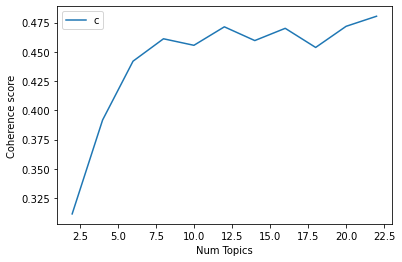

In [71]:
# Show graph
limit=24; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [72]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.3114
Num Topics = 4  has Coherence Value of 0.3917
Num Topics = 6  has Coherence Value of 0.442
Num Topics = 8  has Coherence Value of 0.4612
Num Topics = 10  has Coherence Value of 0.4556
Num Topics = 12  has Coherence Value of 0.4714
Num Topics = 14  has Coherence Value of 0.4596
Num Topics = 16  has Coherence Value of 0.4701
Num Topics = 18  has Coherence Value of 0.4537
Num Topics = 20  has Coherence Value of 0.4718
Num Topics = 22  has Coherence Value of 0.4804


In [246]:
from pprint import pprint
# Select the model and print the topics
optimal_model = model_list[2]
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.127*"coronavirus" + 0.074*"covid" + 0.027*"home" + 0.018*"stay" + '
  '0.016*"mask" + 0.016*"make" + 0.015*"toiletpaper" + 0.013*"virus" + '
  '0.012*"sanitizer" + 0.011*"safe"'),
 (1,
  '0.087*"price" + 0.025*"demand" + 0.019*"due" + 0.017*"oil" + '
  '0.016*"pandemic" + 0.015*"market" + 0.014*"increase" + 0.011*"low" + '
  '0.011*"high" + 0.011*"world"'),
 (2,
  '0.083*"food" + 0.056*"people" + 0.051*"supermarket" + 0.031*"stock" + '
  '0.030*"panic" + 0.024*"buy" + 0.016*"shelf" + 0.015*"buying" + '
  '0.014*"local" + 0.014*"coronavirus"'),
 (3,
  '0.093*"store" + 0.074*"grocery" + 0.031*"work" + 0.030*"worker" + '
  '0.021*"day" + 0.019*"supermarket" + 0.016*"retail" + 0.013*"customer" + '
  '0.012*"essential" + 0.012*"today"'),
 (4,
  '0.121*"covid" + 0.039*"online" + 0.034*"shopping" + 0.025*"coronavirus" + '
  '0.025*"time" + 0.019*"shop" + 0.018*"good" + 0.013*"lockdown" + '
  '0.013*"delivery" + 0.011*"order"'),
 (5,
  '0.053*"consumer" + 0.049*"amp" + 0.034*"covid" 

### Mapping Tweet to Cluster

In [174]:
def format_topics_sentences(ldamodel=lda_model, corpus=corpus, texts=data):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        wp = ldamodel.show_topic(row[0][0])
        topic_keywords = ", ".join([word for word, prop in wp])
        sent_topics_df = sent_topics_df.append(pd.Series([int(row[0][0]), round(row[0][1],4), topic_keywords]), ignore_index=True)
            
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=corpus, texts=data)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,2.0,0.1912,"food, people, supermarket, stock, panic, buy, ...",TRENDING New Yorkers encounter empty supermark...
1,1,0.0,0.1778,"coronavirus, covid, home, stay, mask, make, to...",When couldn find hand sanitizer Fred Meyer tur...
2,2,0.0,0.1782,"coronavirus, covid, home, stay, mask, make, to...",Find out how you can protect yourself and love...
3,3,3.0,0.2285,"store, grocery, work, worker, day, supermarket...",#Panic buying hits #NewYork City anxious shopp...
4,4,2.0,0.2803,"food, people, supermarket, stock, panic, buy, ...",#toiletpaper #dunnypaper #coronavirus #coronav...
...,...,...,...,...,...
44950,44950,2.0,0.2053,"food, people, supermarket, stock, panic, buy, ...",Airline pilots offering stock supermarket shel...
44951,44951,5.0,0.2634,"consumer, amp, covid, business, pandemic, cris...",Response complaint not provided citing COVID r...
44952,44952,0.0,0.1925,"coronavirus, covid, home, stay, mask, make, to...",You know getting tough when rationing toilet p...
44953,44953,0.0,0.2203,"coronavirus, covid, home, stay, mask, make, to...",wrong that the smell hand sanitizer starting t...


### Tweet in Each Topic

In [175]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet


,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.4160,"coronavirus, covid, home, stay, mask, make, to...",Corona virus safety tips Regularly and thoroug...
1,1.0,0.4444,"price, demand, due, oil, pandemic, market, inc...",Economy Low tourism businesses suffer reduced ...
2,2.0,0.3642,"food, people, supermarket, stock, panic, buy, ...",Not lot food left the supermarket tonight eggs...
3,3.0,0.3744,"store, grocery, work, worker, day, supermarket...",#Coronavirus works weekends Which bullsh frank...
4,4.0,0.3657,"covid, online, shopping, coronavirus, time, sh...",Several cyber scams involving false emails tex...
5,5.0,0.4097,"consumer, amp, covid, business, pandemic, cris...",#LDA City Lahore Residential Files Prices Upda...


### Topic Distribution

In [176]:
# Number of Documents for Each Topic
topic_counts = df_topic_sents_keywords['Dominant_Topic'].value_counts()

# Percentage of Documents for Each Topic
topic_contribution = round(topic_counts/topic_counts.sum(), 4)

# Topic Number and Keywords
topic_num_keywords = sent_topics_sorteddf_mallet[['Topic_Num', 'Keywords']]

# Concatenate Column wise
df_dominant_topics = pd.concat([topic_num_keywords, topic_counts, topic_contribution], axis=1)

# Change Column names
df_dominant_topics.columns = ['Dominant_Topic', 'Topic_Keywords', 'Num_Documents', 'Perc_Documents']

# Show
df_dominant_topics

,Dominant_Topic,Topic_Keywords,Num_Documents,Perc_Documents
0.0,0.0,"coronavirus, covid, home, stay, mask, make, to...",7605,0.1692
1.0,1.0,"price, demand, due, oil, pandemic, market, inc...",8172,0.1818
2.0,2.0,"food, people, supermarket, stock, panic, buy, ...",8617,0.1917
3.0,3.0,"store, grocery, work, worker, day, supermarket...",7957,0.1770
4.0,4.0,"covid, online, shopping, coronavirus, time, sh...",5802,0.1291
5.0,5.0,"consumer, amp, covid, business, pandemic, cris...",6802,0.1513


### Sentimental Analysis

In [220]:
from textblob import TextBlob

In [201]:
cluster0= []
cluster1= []
cluster2= []
cluster3= []
cluster4= []
cluster5= []

In [202]:
for i in range(44955):
    if df_dominant_topic.iloc[i][1]==0:
        cluster0.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==1:
        cluster1.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==2:
        cluster2.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==3:
        cluster3.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==4:
        cluster4.append(df_dominant_topic.iloc[i][4])
    elif df_dominant_topic.iloc[i][1]==5:
        cluster5.append(df_dominant_topic.iloc[i][4])

In [204]:
df_cluster0= pd.DataFrame(cluster0, columns=['Text'])
df_cluster1= pd.DataFrame(cluster1, columns=['Text'])
df_cluster2= pd.DataFrame(cluster2, columns=['Text'])
df_cluster3= pd.DataFrame(cluster3, columns=['Text'])
df_cluster4= pd.DataFrame(cluster4, columns=['Text'])
df_cluster5= pd.DataFrame(cluster5, columns=['Text'])

In [217]:
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

In [224]:
df_cluster0['polarity'] = df_cluster0.Text.apply(detect_polarity)
df_cluster1['polarity'] = df_cluster1.Text.apply(detect_polarity)
df_cluster2['polarity'] = df_cluster2.Text.apply(detect_polarity)
df_cluster3['polarity'] = df_cluster3.Text.apply(detect_polarity)
df_cluster4['polarity'] = df_cluster4.Text.apply(detect_polarity)
df_cluster5['polarity'] = df_cluster5.Text.apply(detect_polarity)

In [242]:
ss_C0=df_cluster0['polarity'].mean()
ss_C1=df_cluster1['polarity'].mean()
ss_C2=df_cluster2['polarity'].mean()
ss_C3=df_cluster3['polarity'].mean()
ss_C4=df_cluster4['polarity'].mean()
ss_C5=df_cluster5['polarity'].mean()

In [245]:
print("Sentiment Score of Cluster 0 is ", ss_C0 )
print("Sentiment Score of Cluster 1 is ", ss_C1 )
print("Sentiment Score of Cluster 2 is ", ss_C2 )
print("Sentiment Score of Cluster 3 is ", ss_C3 )
print("Sentiment Score of Cluster 4 is ", ss_C4 )
print("Sentiment Score of Cluster 5 is ", ss_C5 )

Sentiment Score of Cluster 0 is  0.09371884787167292
Sentiment Score of Cluster 1 is  0.050278672751418965
Sentiment Score of Cluster 2 is  0.02027491003587623
Sentiment Score of Cluster 3 is  0.06987026612867239
Sentiment Score of Cluster 4 is  0.09760237715160741
Sentiment Score of Cluster 5 is  0.10615565336265022


### VADER Sentimental Analysis

In [249]:
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [255]:
def sentiment_scores(sentence):
    sentiment = SentimentIntensityAnalyzer()
    return sentiment.polarity_scores(sentence)

In [256]:
df_cluster0['polarity'] = df_cluster0.Text.apply(sentiment_scores)
df_cluster1['polarity'] = df_cluster1.Text.apply(sentiment_scores)
df_cluster2['polarity'] = df_cluster2.Text.apply(sentiment_scores)
df_cluster3['polarity'] = df_cluster3.Text.apply(sentiment_scores)
df_cluster4['polarity'] = df_cluster4.Text.apply(sentiment_scores)
df_cluster5['polarity'] = df_cluster5.Text.apply(sentiment_scores)

In [264]:
df_cluster0= pd.concat([df_cluster0.drop(['polarity'], axis=1), df_cluster0['polarity'].apply(pd.Series)], axis=1)
df_cluster1= pd.concat([df_cluster1.drop(['polarity'], axis=1), df_cluster1['polarity'].apply(pd.Series)], axis=1)
df_cluster2= pd.concat([df_cluster2.drop(['polarity'], axis=1), df_cluster2['polarity'].apply(pd.Series)], axis=1)
df_cluster3= pd.concat([df_cluster3.drop(['polarity'], axis=1), df_cluster3['polarity'].apply(pd.Series)], axis=1)
df_cluster4= pd.concat([df_cluster4.drop(['polarity'], axis=1), df_cluster4['polarity'].apply(pd.Series)], axis=1)
df_cluster5= pd.concat([df_cluster5.drop(['polarity'], axis=1), df_cluster5['polarity'].apply(pd.Series)], axis=1)

In [284]:
sentiment.polarity_scores('couldnt')

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

In [269]:
sa_C0= {'neg': df_cluster0['neg'].mean(), 'neu': df_cluster0['neu'].mean(), 'pos': df_cluster0['pos'].mean(), 'compound': df_cluster0['compound'].mean()}
sa_C1= {'neg': df_cluster1['neg'].mean(), 'neu': df_cluster1['neu'].mean(), 'pos': df_cluster1['pos'].mean(), 'compound': df_cluster1['compound'].mean()}
sa_C2= {'neg': df_cluster2['neg'].mean(), 'neu': df_cluster2['neu'].mean(), 'pos': df_cluster2['pos'].mean(), 'compound': df_cluster2['compound'].mean()}
sa_C3= {'neg': df_cluster3['neg'].mean(), 'neu': df_cluster3['neu'].mean(), 'pos': df_cluster3['pos'].mean(), 'compound': df_cluster3['compound'].mean()}
sa_C4= {'neg': df_cluster4['neg'].mean(), 'neu': df_cluster4['neu'].mean(), 'pos': df_cluster4['pos'].mean(), 'compound': df_cluster4['compound'].mean()}
sa_C5= {'neg': df_cluster5['neg'].mean(), 'neu': df_cluster5['neu'].mean(), 'pos': df_cluster5['pos'].mean(), 'compound': df_cluster5['compound'].mean()}

In [273]:
print(sa_C0)
print(sa_C1)
print(sa_C2)
print(sa_C3)
print(sa_C4)
print(sa_C5)

{'neg': 0.06772912557527948, 'neu': 0.7770281393819821, 'pos': 0.12841538461538454, 'compound': 0.16457075608152524}
{'neg': 0.11955408712677458, 'neu': 0.7921896720509065, 'pos': 0.08825220264317175, 'compound': -0.07304703866862437}
{'neg': 0.1310736915399792, 'neu': 0.7786284089590322, 'pos': 0.09029186491818522, 'compound': -0.11406841128002738}
{'neg': 0.07455799924594678, 'neu': 0.8123187130828174, 'pos': 0.11312391604876239, 'compound': 0.12276291315822613}
{'neg': 0.09018045501551195, 'neu': 0.7865313684936203, 'pos': 0.12328576352981785, 'compound': 0.10207397449155468}
{'neg': 0.07176462805057345, 'neu': 0.8149150249926476, 'pos': 0.11331490738018257, 'compound': 0.12216887680094052}


### Positive, Negative & Neutral words

In [301]:
from nltk.stem.porter import *
stemmer = PorterStemmer()

# apply stemmer for tokenized_tweet
tokenized_tweet = tokenized_tweet.apply(lambda x: [stemmer.stem(i) for i in x])

In [302]:
tokenized_tweet= tokenized_tweet.to_frame()
tokenized_tweet=tokenized_tweet.values

In [303]:
# join tokens into one sentence
for i in range(len(tokenized_tweet)):
    tokenized_tweet[i][0] = ' '.join(tokenized_tweet[i][0])

In [304]:
df['Tweet']  = tokenized_tweet

In [309]:
pos=[]
neg=[]
neu=[]

for i in range(df.shape[0]):
    if df.iloc[i]['Sentiment']== 'Positive' or df.iloc[i]['Sentiment']== 'Extremely Positive':
        pos.append(df.iloc[i]['Tweet'])
        
    elif df.iloc[i]['Sentiment']== 'Negative' or df.iloc[i]['Sentiment']== 'Extremely Negative':
        neg.append(df.iloc[i]['Tweet'])
    
    else:
        neu.append(df.iloc[i]['Tweet'])

In [313]:
print(len(pos), len(neu), len(neg))

19592 8332 17031


In [316]:
from collections import Counter

In [332]:
# Create three Counter objects to store positive, negative and total counts
positive_counts = Counter()
negative_counts = Counter()
neutral_counts = Counter()
total_counts = Counter()
 
for i in range(len(pos)):
    for word in pos[i].lower().split(" "):
        positive_counts[word]+=1
        total_counts[word]+=1
 
 
for i in range(len(neg)):
    for word in neg[i].lower().split(" "):
        negative_counts[word]+=1
        total_counts[word]+=1

        
for i in range(len(neu)):
    for word in neu[i].lower().split(" "):
        neutral_counts[word]+=1
        total_counts[word]+=1
        

In [338]:
pos_neg_ratios = Counter()
 
# Calculate the ratios of positive and negative uses of the most common words
# Consider words to be "common" if they've been used at least 100 times
for term,cnt in list(total_counts.most_common()):
    if(cnt > 100):
        pos_neg_ratio = positive_counts[term] / float(negative_counts[term]+1)
        pos_neg_ratios[term] = pos_neg_ratio


In [344]:
pos_words=[]
neg_words=[]

In [354]:
for i in range(len(pos_neg_ratios.most_common())):
    if pos_neg_ratios.most_common()[i][1]>1.5:
        pos_words.append(pos_neg_ratios.most_common()[i][0])
    else:
        neg_words.append(pos_neg_ratios.most_common()[i][0])

In [372]:
pos_words

['best',
 'love',
 'happi',
 'hero',
 'safe',
 'amaz',
 'appreci',
 'free',
 'thank',
 'grate',
 'gift',
 'great',
 'super',
 'friend',
 'relief',
 'support',
 'special',
 'strong',
 'healthi',
 'commit',
 'profession',
 'safeti',
 'ensur',
 'hand',
 'wish',
 'interest',
 'win',
 'smart',
 'webinar',
 'confid',
 'easi',
 'help',
 'posit',
 'boost',
 'respect',
 'lol',
 'encourag',
 'readi',
 'pretti',
 'sanit',
 'locat',
 '#handsanit',
 'opportun',
 'greater',
 'care',
 'better',
 'ye',
 '#staysaf',
 'won',
 'growth',
 'qualiti',
 'share',
 'join',
 'teacher',
 'dear',
 'approv',
 'benefit',
 'save',
 'valu',
 'fresh',
 'hope',
 'credit',
 'trust',
 'team',
 'huge',
 'true',
 'nice',
 'play',
 'easter',
 'god',
 'neighbor',
 'chariti',
 'pleas',
 'brand',
 'research',
 'launch',
 'sir',
 'perfect',
 'alcohol',
 'well',
 'wash',
 'sure',
 'guidelin',
 'kind',
 'cleaner',
 'card',
 'connect',
 'frontlin',
 'client',
 'good',
 'insight',
 'commun',
 'accept',
 'data',
 'detail',
 'traffic

In [363]:
neg_words

['look',
 'cover',
 'plu',
 'life',
 'daili',
 'send',
 'access',
 'remind',
 'suggest',
 'eye',
 'each',
 'home',
 'mobil',
 'shout',
 'servic',
 'let',
 'toward',
 'effect',
 'counti',
 'california',
 '#coronavirususa',
 'made',
 'shop',
 'water',
 'associ',
 'remain',
 'tomorrow',
 'forward',
 'consid',
 '#consum',
 'felt',
 'took',
 'town',
 'experienc',
 'estat',
 'pack',
 'pub',
 'shelter',
 'everyon',
 'stori',
 'blog',
 'allow',
 'power',
 'possibl',
 'folk',
 'add',
 'addit',
 'question',
 '#retail',
 'aid',
 'close',
 'feel',
 'number',
 'signific',
 'apart',
 'info',
 'found',
 'canadian',
 'invest',
 'facebook',
 'organ',
 'rememb',
 'reduc',
 'regul',
 'bit',
 'towel',
 'quickli',
 'advic',
 'bag',
 'tax',
 'wipe',
 'latest',
 'kit',
 'thursday',
 'inform',
 'insur',
 'hour',
 'store',
 'oper',
 'beer',
 'survey',
 '#toiletpap',
 'joke',
 'respons',
 'also',
 'concern',
 'line',
 'track',
 '#quarantin',
 'work',
 'abl',
 'studi',
 'discuss',
 'second',
 'video',
 'find',
 

### Wordcloud

In [357]:
def create_blank_black_canvas(width, height):
    image = np.zeros((height, width, 3), np.uint8)
    return image

In [376]:
cw=['#coronavirus', '#covid', 'covid']
def remove_cw(string):
    querywords = string.split()
    resultwords  = [word for word in querywords if word.lower() not in cw]
    result = ' '.join(resultwords)
    return result

In [359]:
import cv2

In [377]:
C0_words = ' '.join([text for text in df_cluster0['Text']])
C0_words = remove_cw(C0_words)
wordcloud1 = WordCloud(width=200, height=125, random_state=21, max_font_size=25, background_color='white',colormap='Greens').generate(C0_words)

C1_words = ' '.join([text for text in df_cluster1['Text']])
C1_words= remove_cw(C1_words)
wordcloud2 = WordCloud(width=200, height=125, random_state=21, max_font_size=25,background_color='white',colormap='Reds').generate(C1_words)

C2_words = ' '.join([text for text in df_cluster2['Text']])
C2_words = remove_cw(C2_words)
wordcloud3 = WordCloud(width=200, height=125, random_state=21, max_font_size=25,background_color='white',colormap='Greens').generate(C2_words)

C3_words = ' '.join([text for text in df_cluster3['Text']])
C3_words= remove_cw(C3_words)
wordcloud4 = WordCloud(width=200, height=125, random_state=21, max_font_size=25,background_color='white',colormap='Reds').generate(C3_words)

C4_words = ' '.join([text for text in df_cluster4['Text']])
C4_words=remove_cw(C4_words)
wordcloud5 = WordCloud(width=200, height=125, random_state=21, max_font_size=25,background_color='white',colormap='Greens').generate(C4_words)

C5_words = ' '.join([text for text in df_cluster5['Text']])
C5_words=remove_cw(C5_words)
wordcloud6 = WordCloud(width=200, height=125, random_state=21, max_font_size=25,background_color='white',colormap='Reds').generate(C5_words)

wordcloud1.to_file("wordCloud1.png")
wordcloud2.to_file("wordCloud2.png")
wordcloud3.to_file("wordCloud3.png")
wordcloud4.to_file("wordCloud4.png")
wordcloud5.to_file("wordCloud5.png")
wordcloud6.to_file("wordCloud6.png")

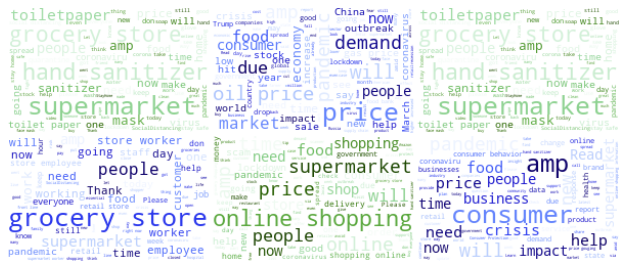

In [379]:
canvas = create_blank_black_canvas(600, 250)
# create text from just normal tweets

tl = cv2.imread('wordCloud1.png')
tm = cv2.imread('wordCloud2.png')
tr = cv2.imread('wordCloud3.png')
bl = cv2.imread('wordCloud4.png')
bm = cv2.imread('wordCloud5.png')
br = cv2.imread('wordCloud6.png')

canvas[0:125, 0:200] = tl
canvas[0:125, 200:400] = tm
canvas[0:125, 400:600] = tl
canvas[125:250, 0:200] = bl
canvas[125:250, 200:400] = bm
canvas[125:250, 400:600] = br

plt.figure(figsize=(11,9))
plt.imshow(canvas,interpolation="bilinear")
plt.axis('off')
plt.show()

### Factor Estimation

,Text,neg,neu,pos,compound
0,When couldn find hand sanitizer Fred Meyer tur...,0.000,0.846,0.154,0.3506
1,Find out how you can protect yourself and love...,0.000,0.606,0.394,0.7579
2,Voting the age #coronavirus hand sanitizer #Su...,0.000,0.652,0.348,0.4939
3,TWITTER pharmacist sell hand sanitizer for liv...,0.205,0.675,0.120,-0.6166
4,#AirSewa not providing #webchecin customers fr...,0.134,0.685,0.181,0.4019
...,...,...,...,...,...
7600,,0.000,0.000,0.000,0.0000
7601,all really shitting that much more home #COVID...,0.256,0.744,0.000,-0.4754
7602,light Sterilizer Sanitizer for your mask and m...,0.000,0.697,0.303,0.7506
7603,You know getting tough when rationing toilet p...,0.099,0.724,0.178,0.2960
